In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import pandas as pd
from sklearn import linear_model
import math
import gym
import myfrozen
import pickle
import img_utils
import os
from gym.envs.registration import register

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Lambda
from keras.layers.advanced_activations import LeakyReLU, Softmax
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras import backend as K

import matplotlib.pyplot as plt

import sys
from copy import deepcopy
import h5py

Using TensorFlow backend.


# Generating

In [3]:
import h5py
from keras.models import load_model

In [4]:
generator = load_model('models/rewards2/generator.h5')

/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
OBSERVATION_SPACE = 64
ACTION_SPACE = 4
        
def to_onehot(size,value):
    my_onehot = np.zeros((size))
    my_onehot[value] = 1.0
    return my_onehot
    
def heatmap2d(hm_mat, title='', fig_num=1, text=True):
    plt.figure(fig_num)
    plt.imshow(hm_mat, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
            
    if text:
        for y in range(hm_mat.shape[0]):
            for x in range(hm_mat.shape[1]):
                plt.text(x, y, '%.1f' % hm_mat[y, x],
                horizontalalignment='center',
                verticalalignment='center',
            )
            
def compute_reward(s,new_s,a,gen_imgs):
    zerostates = {12, 21, 29, 37, 44, 52, 58}
    s = to_onehot(OBSERVATION_SPACE,s)
    new_s = to_onehot(OBSERVATION_SPACE,new_s)
    a = to_onehot(ACTION_SPACE,a)
    vectorized = np.hstack((s,new_s,a))
    index = list(zerostates)
    vectorized = np.delete(vectorized, index)
    return np.dot(gen_imgs,vectorized)

def fill_rewards(gen_imgs):
    tofill = np.zeros((OBSERVATION_SPACE,OBSERVATION_SPACE,ACTION_SPACE)) 
    for s in xrange(0,OBSERVATION_SPACE):
        for new_s in xrange(0,OBSERVATION_SPACE):
            for a in xrange(0,ACTION_SPACE):
                tofill[(s,new_s,a)] = compute_reward(s,new_s,a,gen_imgs)
    sub = tofill[0, :, :]
    sub = np.max(sub,axis=1)
    return sub

In [6]:
def heatmap2d_vf(qtable,title,fig_num):
    heatmap2d(np.reshape(np.expand_dims(np.max(qtable,axis=1),1), (8, 8)), title=title, fig_num=fig_num, text=True)
    plt.savefig("experiments_rewards/%d.png" % fig_num, format='png')

In [201]:
noise = np.random.normal(0, 1, (1, 16))
gen_imgs = generator.predict(noise)
gen_imgs = np.squeeze(gen_imgs, axis=0)
gen_imgs = np.squeeze(gen_imgs, axis=2)
gen_imgs = np.squeeze(gen_imgs, axis=1)

In [202]:
hm_mat = fill_rewards(gen_imgs)
hm_mat = np.expand_dims(hm_mat,axis=1)
a = np.reshape(hm_mat, (8, 8))

In [203]:
rowindex , colindex = numpy.unravel_index(a.argmax(), a.shape)

In [204]:
print(rowindex , colindex)

7 7


In [205]:
name='FFFFFXXXXXXXXO8x8-v%d' % 1
env = make_environment(name,iteration,rowindex,colindex)

namemod='FFFFFXXXXXXXXMOx8-v%d' % 1
envmod = make_environment_modified(namemod,iteration,rowindex,colindex)

In [206]:
env.render()


FFFFFFFF
HFFFFFFF
FFFHFFFF
FFFFHHFF
FFFFFFFF
FFFFFFHF
SHHFFFFF
FFFFFFFG


In [ ]:
envmod.render()

In [34]:
qmodel, wpmodel, skip, timodel = trainer(env,epochs=allepochs,use_model=True)

Game #: 2000
Moves this round 29
Final Position:
  (Right)
FFFFFFFG
SFFHFFFF
FFFFFFFF
FHFFFFFF
HFHFFFFF
FFFFFFHF
FFFFHHFF
FFFFFFFF
Wins/Losses 53/1947


In [37]:
qmod, wpmod, skip, timod = trainer(envmod,epochs=allepochs,Q=qmodel.copy(),use_model=False)

Game #: 2000
Moves this round 91
Final Position:
  (Down)
FFFFFFFF
FFFHFFFS
FFFFFFFF
FHFFFFFF
HFHFFFFF
FFFFFFHF
FFFFHHFF
GFFFFFFF
Wins/Losses 75/1925


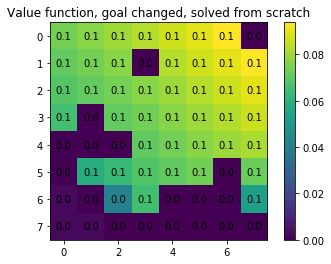

In [39]:
heatmap2d_vf(qmodel,'Value function, goal changed, solved from scratch',fig_num=12345)

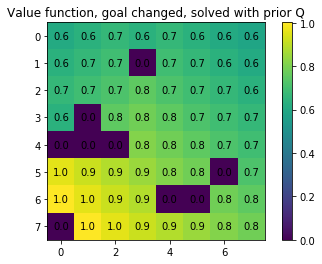

In [38]:
heatmap2d_vf(qmod,'Value function, goal changed, solved with prior Q',fig_num=1234)

In [14]:
def fill_dict(D,MY_ENV_NAME,env,envmod,qmodel,qmod,qscratch,wpmodel,wpmod,wpscratch,timodel,timod,tiscratch):
    D[MY_ENV_NAME]["env"] = env
    D[MY_ENV_NAME]["envmod"] = envmod
    D[MY_ENV_NAME]["qmodel"] = qmodel
    D[MY_ENV_NAME]["qmod"] = qmod
    D[MY_ENV_NAME]["qscratch"] = qscratch
    D[MY_ENV_NAME]["wpmodel"] = wpmodel
    D[MY_ENV_NAME]["wpmod"] = wpmod
    D[MY_ENV_NAME]["wpscratch"] = wpscratch
    D[MY_ENV_NAME]["timodel"] = timodel
    D[MY_ENV_NAME]["timod"] = timod
    D[MY_ENV_NAME]["tiscratch"] = tiscratch
    return D

Done


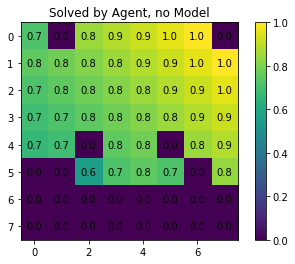

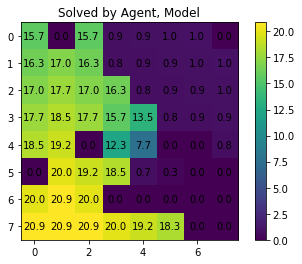

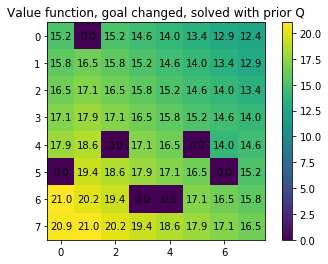

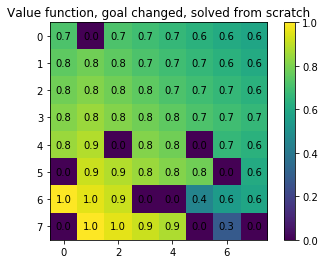

In [17]:
wp_per_game = list()
wpmodel_per_game = list()
wpmod_per_game = list()
wpscratch_per_game = list()

ti_per_game = list()
timodel_per_game = list()
timod_per_game = list()
tiscratch_per_game = list()

pols = list()
polsscratch = list()

allepochs=2000
target_iterations = 1
iteration = 0

counter_done = 0

D = {}

#while True:
while True:
#for iteration in range(5):
    if counter_done == target_iterations:
        break

    noise = np.random.normal(0, 1, (1, 16))
    gen_imgs = generator.predict(noise)
    gen_imgs = np.squeeze(gen_imgs, axis=0)
    gen_imgs = np.squeeze(gen_imgs, axis=2)
    gen_imgs = np.squeeze(gen_imgs, axis=1)
    
    hm_mat = fill_rewards(gen_imgs)
    hm_mat = np.expand_dims(hm_mat,axis=1)
    
    a = np.reshape(hm_mat, (8, 8))
    
    rowindex , colindex = numpy.unravel_index(a.argmax(), a.shape)
    
    if a.max() < 0.5 or a.max() > 2.0 or np.sum(a)>3.0 or rowindex==colindex:
        continue
    else:
        #rowindex , colindex = numpy.unravel_index(a.argmax(), a.shape)
    
        name='FXXXXO8x8-v%d' % iteration
        env = make_environment(name,iteration,rowindex,colindex)

        namemod='FXXXXMOx8-v%d' % iteration
        envmod = make_environment_modified(namemod,iteration,rowindex,colindex)
    
        qmodel, wpmodel, skip, timodel = trainer(env,epochs=allepochs,use_model=True)
        if skip==True:
            del env, envmod, qmodel
            iteration += 1
            continue
        q, wp, skip, ti = trainer(env,epochs=allepochs,use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        qmod, wpmod, skip, timod = trainer(envmod,epochs=allepochs,Q=qmodel.copy(),use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        qscratch, wpscratch, skip, tiscratch = trainer(envmod,epochs=allepochs,use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        
        wp_per_game.append(wp)
        ti_per_game.append(ti)
        
        wpmodel_per_game.append(wpmodel)
        timodel_per_game.append(timodel)
        
        wpmod_per_game.append(wpmod)
        timod_per_game.append(timod)
        
        wpscratch_per_game.append(wpscratch)
        tiscratch_per_game.append(tiscratch)
        
        pols.append(show_policy(envmod,qmod))
        polsscratch.append(show_policy(envmod,qscratch))
        
        heatmap2d_vf(q,'Solved by Agent, no Model',fig_num=int(str(iteration)+'1'))
        
        heatmap2d_vf(qmodel,'Solved by Agent, Model',fig_num=int(str(iteration)+'2'))
                
        heatmap2d_vf(qmod,'Value function, goal changed, solved with prior Q',fig_num=int(str(iteration)+'3'))
        
        heatmap2d_vf(qscratch,'Value function, goal changed, solved from scratch',fig_num=int(str(iteration)+'4'))
    
        #del qmodel, qmod, qscratch, env, envmod
        
        iteration += 1
        
        counter_done += 1
        
        D[name] = {}
        D=fill_dict(D,name,env,envmod,qmodel,qmod,qscratch,wpmodel,wpmod,wpscratch,timodel,timod,tiscratch)
        
    print("Done")

In [ ]:
env.render()

In [210]:
envmod.render()

  (Left)
FFFFFFFF
FFFFFFFF
FFFHFFFS
FFHFFHFF
FFFFHFFF
FFFFFFFF
HHFFFFHF
GFFFFFFF


In [12]:
wp_per_game, wpmodel_per_game, wpmod_per_game, wpscratch_per_game

([0.6175, 0.739], [0.0305, 0.686], [0.487, 0.5115], [0.509, 0.4975])

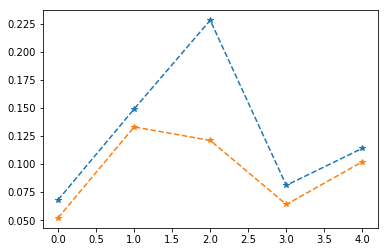

In [19]:
plt.plot(np.arange(0,5), np.array(wpmod_per_game), '*--', np.arange(0,5), np.array(wpscratch_per_game), '*--')

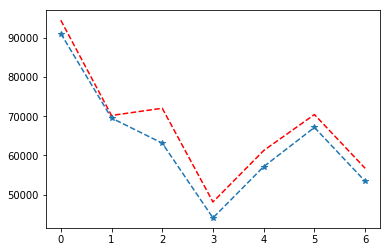

In [43]:
plt.plot(np.arange(0,7), np.array(timod_per_game), 'r--', np.arange(0,7), np.array(tiscratch_per_game), '*--')

In [13]:
ti_per_game, timodel_per_game, timod_per_game, tiscratch_per_game

([25535, 28513], [116104, 27575], [32695, 35216], [31195, 36216])

In [7]:
def make_environment(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': iteration, 'rowindex': rowindex, 'colindex': colindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

def make_environment_modified(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': iteration, 'rowindex': colindex, 'colindex': rowindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

In [8]:
def run_episode(env,Q,learning_rate,gamma,episode,max_steps,use_model=True,epsilon=0.5):
    observation = env.reset()
    done = False
    t_reward = 0
    #max_steps = 60
    move_counter = 0
    for j in range(max_steps):
        if done:
            break

        curr_state = observation
        
        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,4)
        else:        
            action = np.argmax(Q[curr_state,:])
        #action = eps_greedy(curr_state, Q, epsilon=.5)
        
        move_counter+=1
        
        observation, true_reward, done, info = env.step(action)
        #true_reward = deepcopy(reward)
        
        if use_model:
            reward = compute_reward(curr_state,observation,action,gen_imgs)
        else:
            reward = deepcopy(true_reward)
            
        t_reward += reward

        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter, true_reward

In [9]:
def trainer(env,epochs=1000,learning_rate = 0.81,discount = 0.96, use_model=False, **kwargs):
    
    #reward_per_ep = list()
    wins = 0
    losses = 0
    max_steps = 100
    wins_threshold = 5
    skip = False
    t_interactions = 0
    epsilon=0.90
    min_epsilon=0.01
    
    if not 'Q' in kwargs:
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        #Q = np.random.rand(env.observation_space.n, env.action_space.n)
    else:
        Q = kwargs.get('Q', None)
    
    for i in range(epochs):

        Q, t_reward, done, move_counter, true_reward = run_episode(env,Q,learning_rate,discount,i,
                                                                   max_steps=max_steps,use_model=use_model,epsilon=epsilon)
        
        t_interactions += move_counter
        #reward_per_ep.append(t_reward)

        if done:
            if true_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        else:
            if move_counter==max_steps:
                losses += 1
        
        if i == 500 and wins < wins_threshold:
            skip = True
            break
        
        #time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        if epsilon > min_epsilon:
            epsilon -= (1.0/epochs)
    winpercent = float(wins/epochs)
    return Q, winpercent, skip, t_interactions

# A TEST

In [10]:
def show_policy(env,Q):
    A2A=['<','v','>','^']
    
    OBSERVATION_SPACE = env.observation_space.n
    ACTION_SPACE = env.action_space.n
    OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
    STATEGRID = np.zeros((OBS_SQR,OBS_SQR))
    
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')

    obs_sqr = math.sqrt(OBSERVATION_SPACE)

    working_state = STATEGRID.copy()
    
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(Q[index,:])
            grid[x,y] = A2A[action]
    return grid

In [215]:
show_policy(envmod,qmod)

array([[u'v', u'v', u'<', u'<', u'<', u'<', u'v', u'v'],
       [u'v', u'v', u'v', u'<', u'<', u'<', u'v', u'v'],
       [u'>', u'v', u'<', u'<', u'^', u'>', u'v', u'<'],
       [u'v', u'v', u'<', u'v', u'<', u'<', u'v', u'<'],
       [u'v', u'v', u'v', u'v', u'<', u'v', u'<', u'<'],
       [u'>', u'>', u'v', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'v', u'v', u'v', u'<', u'<', u'^'],
       [u'>', u'<', u'<', u'<', u'<', u'<', u'<', u'^']], dtype='<U2')

In [216]:
envmod.render()

  (Left)
FFFFFFFF
FFFFFFFF
FFFHFFFS
FFHFFHFF
FFFFHFFF
FFFFFFFF
HHFFFFHF
GFFFFFFF


In [214]:
show_policy(envmod,qscratch)

array([[u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<']], dtype='<U2')